In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import plotly.express as px

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import librosa
import librosa.display
import IPython.display as ipd

import sklearn

import warnings
warnings.filterwarnings('ignore')

## SECCIÓ 3: DEFINICIÓ DE MODELS
### 3.1 KNN

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Separar característiques (X) i variable objectiu (y)
train_csv_1 = pd.read_csv('train_csv_1_imputed.csv')
val_csv = pd.read_csv('val_df_imputed.csv')
X_train = train_csv_1.drop(columns=['Realornot'])  # Excloure la variable objectiu
y_train = train_csv_1['Realornot']  # Variable objectiu

X_val = val_csv.drop(columns=['Realornot'])
y_val = val_csv['Realornot']


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from hyperopt import hp, fmin, tpe, space_eval
import numpy as np

RANDOM_SEED = 42

# Funció objectiu per optimitzar els hiperparàmetres de KNN
def objective(params):
    params = {
        'n_neighbors': int(params['n_neighbors']),
        'metric': params['metric'],
        'weights': params['weights']
    }

    clf = KNeighborsClassifier(**params)

    score = cross_val_score(
        clf,
        X_train,
        y_train,
        scoring="accuracy",
        cv=StratifiedKFold(shuffle=True, random_state=RANDOM_SEED)
    ).mean()

    print(f"Accuracy de {score:.3f} amb els paràmetres: {params}")
    return -score

space = {
    'n_neighbors': hp.choice('n_neighbors', np.arange(1, 31, 1, dtype=int)),  # Prova de 1 a 30 veïns
    'metric': hp.choice('metric', ['euclidean', 'manhattan', 'minkowski']),  # Diferents mètriques
    'weights': hp.choice('weights', ['uniform', 'distance'])  # Pesos uniformes o basats en distància
}

np.random.seed(RANDOM_SEED)

optimal = fmin(
    fn=objective,         
    space=space,            
    algo=tpe.suggest,       
    max_evals=20,           
    timeout=300,            
    rstate=np.random.default_rng(RANDOM_SEED)  
)

optimal_params = space_eval(space, optimal)
print(f"Paràmetres òptims: {optimal_params}")


Accuracy de 0.816 amb els paràmetres: {'n_neighbors': 25, 'metric': 'manhattan', 'weights': 'uniform'}
Accuracy de 0.840 amb els paràmetres: {'n_neighbors': 10, 'metric': 'manhattan', 'weights': 'distance'}
Accuracy de 0.834 amb els paràmetres: {'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'uniform'}
Accuracy de 0.833 amb els paràmetres: {'n_neighbors': 13, 'metric': 'euclidean', 'weights': 'distance'}
Accuracy de 0.830 amb els paràmetres: {'n_neighbors': 16, 'metric': 'manhattan', 'weights': 'uniform'}
Accuracy de 0.825 amb els paràmetres: {'n_neighbors': 23, 'metric': 'manhattan', 'weights': 'distance'}
Accuracy de 0.825 amb els paràmetres: {'n_neighbors': 21, 'metric': 'euclidean', 'weights': 'distance'}
Accuracy de 0.814 amb els paràmetres: {'n_neighbors': 2, 'metric': 'minkowski', 'weights': 'uniform'}
Accuracy de 0.823 amb els paràmetres: {'n_neighbors': 22, 'metric': 'manhattan', 'weights': 'uniform'}
Accuracy de 0.840 amb els paràmetres: {'n_neighbors': 10, 'metric': 'ma

<div class="alert alert-success">
Paràmetres òptims: {'metric': 'manhattan', 'n_neighbors': np.int64(10), 'weights': 'distance'}
</div>

In [5]:
knn_model = KNeighborsClassifier(n_neighbors=10,metric='manhattan', weights='distance')

knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [6]:
# Predir la variable objectiu pel conjunt de validació
y_pred = knn_model.predict(X_val)

In [7]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitud del model: {accuracy:.2f}")

# Informe de classificació
print("\nInforme de classificació:")
print(classification_report(y_val, y_pred))

Exactitud del model: 0.84

Informe de classificació:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1773
           1       0.79      0.91      0.85      1788

    accuracy                           0.84      3561
   macro avg       0.85      0.84      0.84      3561
weighted avg       0.85      0.84      0.84      3561



Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1773
           1       0.79      0.91      0.85      1788

    accuracy                           0.84      3561
   macro avg       0.85      0.84      0.84      3561
weighted avg       0.85      0.84      0.84      3561

Confusion Matrix (Validation):
[[1351  422]
 [ 153 1635]]
Accuracy: 0.8385


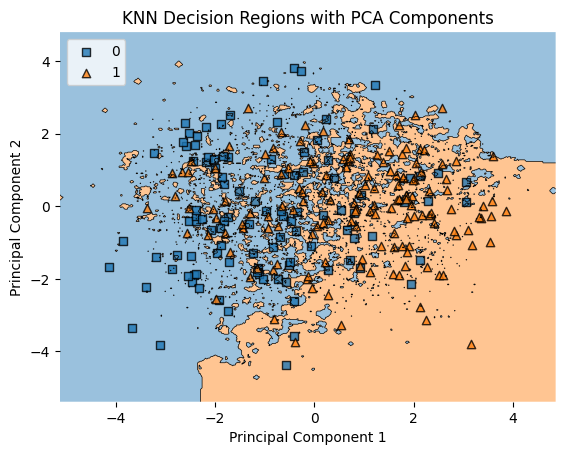

In [8]:
##VISUALITZAR EL DIAGRAMA DE REGIONS
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

knn_model = KNeighborsClassifier(n_neighbors=10,metric='manhattan', weights='distance')
knn_model.fit(X_train, y_train)
y_val_pred = knn_model.predict(X_val)

print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

subset_size = 250  
X_val_pca_subset = X_val_pca[:subset_size]
y_val_subset = y_val[:subset_size]

knn_model.fit(X_train_pca, y_train)
plot_decision_regions(X_val_pca_subset, y_val_subset.values, knn_model)
plt.title('KNN Decision Regions with PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.show()

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from distutils.version import LooseVersion

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=cmap(idx),
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib._version_) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')

KNN fa overfitting? Sembla que amb el diagrama sí, anem a comprovar predint amb el conjunt d'entrenament

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_model = KNeighborsClassifier(n_neighbors=10, metric='manhattan', weights='distance')

# Entrenar el model amb les dades d'entrenament
knn_model.fit(X_train, y_train)

y_train_pred = knn_model.predict(X_train)

# Avaluar el model sobre el conjunt d'entrenament
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Exactitud del model sobre el conjunt d'entrenament: {accuracy:.2f}")

# Informe complet de classificació
print("\nInforme de classificació (conjunt d'entrenament):")
print(classification_report(y_train, y_train_pred))


Exactitud del model sobre el conjunt d'entrenament: 1.00

Informe de classificació (conjunt d'entrenament):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7092
           1       1.00      1.00      1.00      7151

    accuracy                           1.00     14243
   macro avg       1.00      1.00      1.00     14243
weighted avg       1.00      1.00      1.00     14243



<div class="alert alert-success">
Sí que fa overfitting, ja que memoritza les dades del conjunt d'entrenament, i quan veu noves falla
</div>

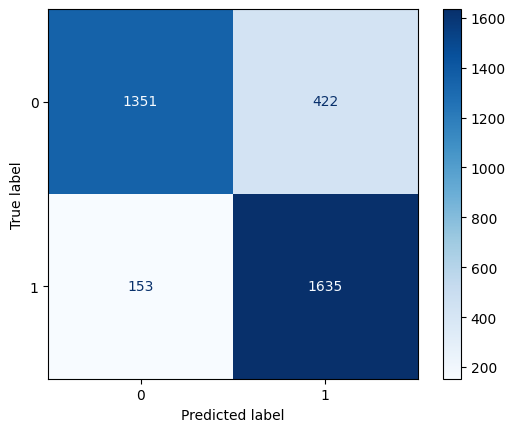

In [ ]:
##MATRIU DE CONFUSIÓ PER A VAL
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')


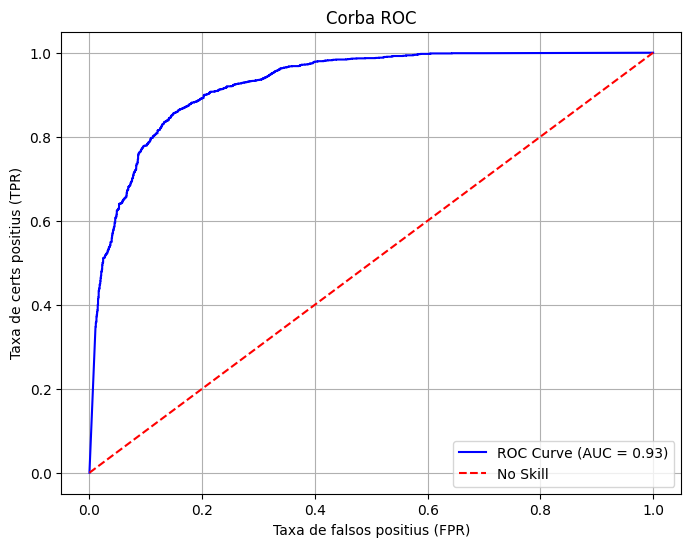

In [11]:
## ROC AUC SCORE
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probs = knn_model.predict_proba(X_val)[:, 1]  # La segona columna conté les probabilitats de classe 1

fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# Calcular l'AUC
auc_score = roc_auc_score(y_val, y_probs)

# Crear el gràfic de la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='No Skill')  # Línia diagonal
plt.xlabel("Taxa de falsos positius (FPR)")
plt.ylabel("Taxa de certs positius (TPR)")
plt.title("Corba ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


### 3.2 SVM

In [22]:
##SVM PER A CONJUNT VAL
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1]
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Millors paràmetres: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_

y_pred_best = best_svm.predict(X_val)
print("Informe de classificació per al millor model:")
print(classification_report(y_val, y_pred_best))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Millors paràmetres: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Informe de classificació per al millor model:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1773
           1       0.85      0.92      0.88      1788

    accuracy                           0.88      3561
   macro avg       0.88      0.88      0.88      3561
weighted avg       0.88      0.88      0.88      3561



In [37]:
## FER EL MATEIX AMB TRAIN
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

svm_model = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)

# Entrenar el model amb les dades d'entrenament
svm_model.fit(X_train, y_train)

# Predir les classes per les dades d'entrenament
y_train_pred = svm_model.predict(X_train)

accuracy = accuracy_score(y_train, y_train_pred)
print(f"Exactitud del model sobre el conjunt d'entrenament: {accuracy:.2f}")

# Informe complet de classificació
print("\nInforme de classificació (conjunt d'entrenament):")
print(classification_report(y_train, y_train_pred))
print(f"Precisió: {accuracy_score(y_train, y_train_pred):.3f}")


Exactitud del model sobre el conjunt d'entrenament: 0.92

Informe de classificació (conjunt d'entrenament):
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      7092
           1       0.89      0.95      0.92      7151

    accuracy                           0.92     14243
   macro avg       0.92      0.92      0.92     14243
weighted avg       0.92      0.92      0.92     14243

Precisió: 0.916


In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

svm_model = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)

# Entrenar el model amb les dades d'entrenament
svm_model.fit(X_train, y_train)

# Predir les classes per les dades de validació
y_pred = svm_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitud del model: {accuracy:.2f}")

# Avaluar el rendiment del model
print("Informe de classificació:")
print(classification_report(y_val, y_pred))
print(f"Precisió: {accuracy_score(y_val, y_pred):.3f}")


Exactitud del model: 0.88
Informe de classificació:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1773
           1       0.85      0.92      0.88      1788

    accuracy                           0.88      3561
   macro avg       0.88      0.88      0.88      3561
weighted avg       0.88      0.88      0.88      3561

Precisió: 0.879


Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1773
           1       0.85      0.92      0.88      1788

    accuracy                           0.88      3561
   macro avg       0.88      0.88      0.88      3561
weighted avg       0.88      0.88      0.88      3561

Confusion Matrix (Validation):
[[1486  287]
 [ 144 1644]]
Accuracy: 0.8790


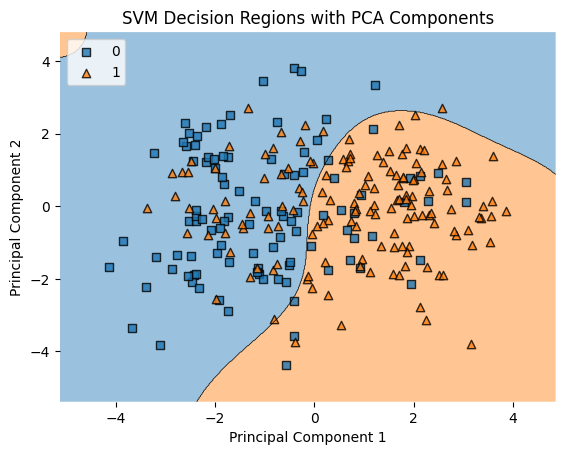

In [32]:
##DIAGRAMA DE REGIONS PER A SVM
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

svm_model = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm_model.fit(X_train, y_train)
y_val_pred = svm_model.predict(X_val)

print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

subset_size = 250  # Define the subset size
X_val_pca_subset = X_val_pca[:subset_size]
y_val_subset = y_val[:subset_size]

svm_model.fit(X_train_pca, y_train)
plot_decision_regions(X_val_pca_subset, y_val_subset.values, svm_model)
plt.title('SVM Decision Regions with PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.show()

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from distutils.version import LooseVersion

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=cmap(idx),
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib._version_) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')

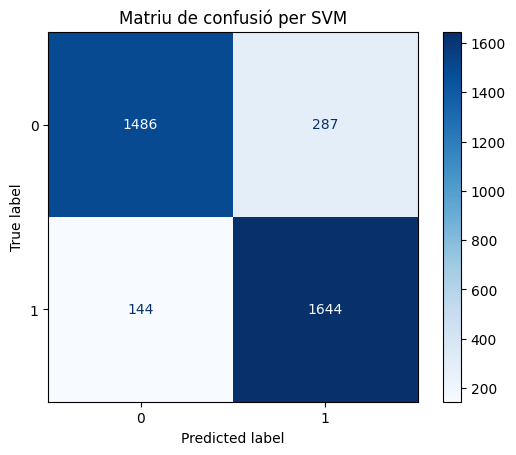

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriu de confusió
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriu de confusió per SVM")
plt.show()


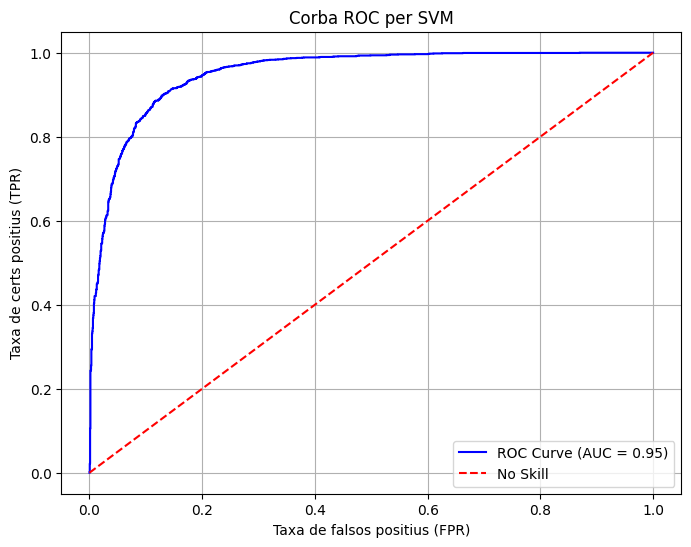

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

svm_model_prob = SVC(kernel='rbf', C=10, gamma=0.1, probability=True, random_state=42)
svm_model_prob.fit(X_train, y_train)

y_probs = svm_model_prob.predict_proba(X_val)[:, 1]

# Calcular les coordenades de la corba ROC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
auc_score = roc_auc_score(y_val, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='No Skill')
plt.xlabel("Taxa de falsos positius (FPR)")
plt.ylabel("Taxa de certs positius (TPR)")
plt.title("Corba ROC per SVM")
plt.legend(loc="lower right")
plt.grid()
plt.show()


### 3.3 Arbre de decisió

In [12]:
## TROBAR PARÀMETRES ÒPTIMS PER A L'ARBRE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
print(f"Millors paràmetres: {grid_search.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Millors paràmetres: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear el model d'arbre de decisió
tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=2, random_state=42)

# Entrenar el model amb les dades d'entrenament
tree_model.fit(X_train, y_train)

# Predir les classes per al conjunt de validació
y_pred = tree_model.predict(X_val)

print("Informe de classificació (VAL):")
print(classification_report(y_val, y_pred))
print(f"Precisió: {accuracy_score(y_val, y_pred):.3f}")


Informe de classificació (VAL):
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1773
           1       0.74      0.86      0.80      1788

    accuracy                           0.78      3561
   macro avg       0.79      0.78      0.77      3561
weighted avg       0.79      0.78      0.77      3561

Precisió: 0.777


In [14]:
##FER EL MATEIX PER A TRAIN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear el model d'arbre de decisió
tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=2, random_state=42)

# Entrenar el model amb les dades d'entrenament
tree_model.fit(X_train, y_train)

# Predir les classes per al conjunt d'entrenament
y_train_pred = tree_model.predict(X_train)

# Avaluar el rendiment del model sobre el conjunt d'entrenament
print("Informe de classificació (conjunt d'entrenament):")
print(classification_report(y_train, y_train_pred))
print(f"Precisió: {accuracy_score(y_train, y_train_pred):.3f}")


Informe de classificació (conjunt d'entrenament):
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      7092
           1       0.81      0.91      0.86      7151

    accuracy                           0.85     14243
   macro avg       0.85      0.85      0.85     14243
weighted avg       0.85      0.85      0.85     14243

Precisió: 0.849


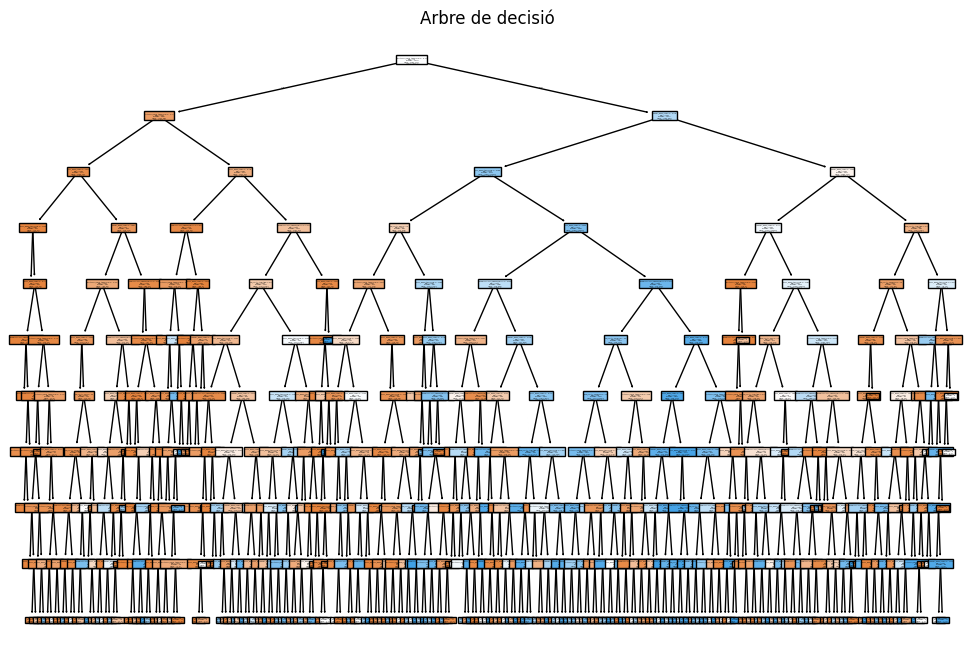

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualitzar l'arbre de decisió
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=X_train.columns, class_names=['Classe 0', 'Classe 1'], filled=True)
plt.title("Arbre de decisió")
plt.show()


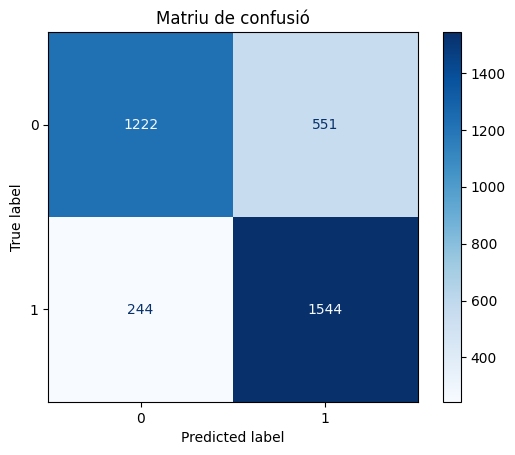

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = tree_model.predict(X_val)

# Calcular la matriu de confusió
cm = confusion_matrix(y_val, y_pred)

# Mostrar la matriu de confusió
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriu de confusió")
plt.show()


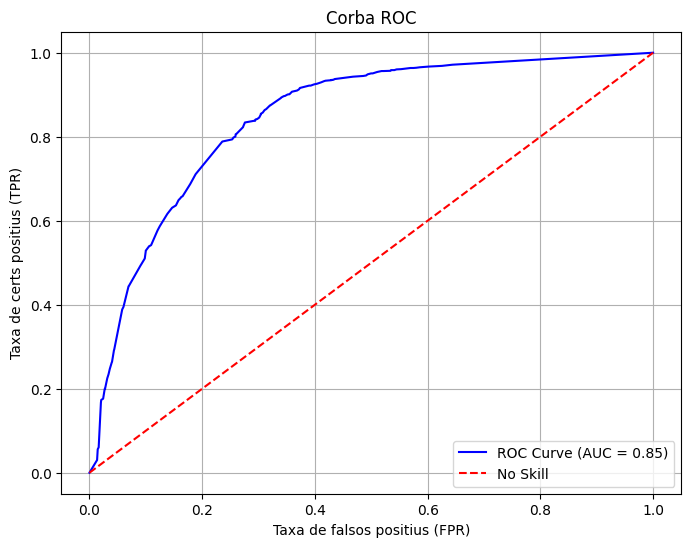

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probs = tree_model.predict_proba(X_val)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_val, y_probs)

auc_score = roc_auc_score(y_val, y_probs)

# Crear el gràfic de la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='No Skill') 
plt.xlabel("Taxa de falsos positius (FPR)")
plt.ylabel("Taxa de certs positius (TPR)")
plt.title("Corba ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


ARBRES DE DECISIÓ NO AJUSTA TAN BÉ COM KNN O SVM